#### A General Algorithm for Cardiac CT Flip Detection using Quadrant Pixel Summation

For cardiac scans, there exists no clean up directory: Manually check for 160 scans for trainning. 
Goal: creat a function such that given mask, the function outputs axes to flip on if mask indicates potential flipping. 

Data Preparation  
1. For each subject, we have three lung masks, one for each view (axial, coronal and saggital). 
2. Manually generate Left-Right (LR), Top-Bottom (TB) and Front-Back (FB) flips and store Niftys in specified subdirectories.

Method 
1. Randomly sample 200 subjects from MESA Ex1, clean up then conduct manual flip generation per step (2) in data preparation. 
2. Extract the lung mask per subject, divide each mask into four quadrants and sum up the pixels in each quadrant, thereby creating a 3x2x2 tensor for each subject. 
3. Train a support vector classifier on 4 classes x 200 scan per class = 800 scans; save the classifier and call for future function. 

In [4]:
# Import packages
import nibabel as nib
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd 
from nilearn import plotting
from myutils import PLF # This is a plotting function written by Soroush for better visualization. 
import seaborn as sns 
import random 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm
from utils import ParallelMe

In [2]:
# # From the cleanup file directory, obtain a list of subjects. 
# Dir = "/DATA/cleanup_data/data_MESA/MESA_Ex1/MESA_Ex1_CAC/"

# Sub = []
# for subdir_name in os.listdir(Dir):
#     subdir_path = os.path.join(Dir, subdir_name)
    
#     if os.path.isdir(subdir_path):
#         patient_id = subdir_name
#         Sub.append(patient_id)

# # Randomly sample 100 subjects to test algo
# rand_idx = random.sample(range(len(Sub)), 200)

# Sampled_sub = []
# for i in rand_idx: 
#     Sampled_sub.append(Sub[i])
    
# # Sort the ID's in ascending order
# Sub_sorted = sorted(Sampled_sub, key=int)
  
# print(Sub_sorted)
# print(len(Sub_sorted))

['3010406', '3010414', '3011194', '3011232', '3011399', '3011704', '3011933', '3013561', '3014037', '3014061', '3014274', '3014410', '3014622', '3014673', '3014940', '3015025', '3015700', '3015815', '3016552', '3016900', '3017567', '3018407', '3018679', '3018741', '3019101', '3019845', '3022374', '3022862', '4010280', '4010612', '4011031', '4011562', '4011740', '4011783', '4012100', '4012631', '4012801', '4013638', '4013891', '4015720', '4015967', '4015983', '4016939', '4017935', '4018214', '4018389', '4018800', '4018877', '4019164', '4019261', '4019750', '4019970', '4021320', '4021959', '4022050', '4022130', '4022629', '4022874', '5010160', '5010195', '5010659', '5010888', '5011230', '5011485', '5011833', '5012236', '5012562', '5012570', '5012902', '5013143', '5014220', '5014778', '5014816', '5014891', '5015260', '5015464', '5015472', '5015952', '5016002', '5016363', '5016894', '5017432', '5017513', '5017548', '5017980', '5018099', '5018382', '5018790', '5018870', '5018960', '5021685'

In [2]:
Sub_sorted = ['3010406', '3010414', '3011194', '3011232', '3011399', '3011704', '3011933', '3013561', '3014037', '3014061', '3014274', '3014410', '3014622', '3014673', '3014940', '3015025', '3015700', '3015815', '3016552', '3016900', '3017567', '3018407', '3018679', '3018741', '3019101', '3019845', '3022374', '3022862', '4010280', '4010612', '4011031', '4011562', '4011740', '4011783', '4012100', '4012631', '4012801', '4013638', '4013891', '4015720', '4015967', '4015983', '4016939', '4017935', '4018214', '4018389', '4018800', '4018877', '4019164', '4019261', '4019750', '4019970', '4021320', '4021959', '4022050', '4022130', '4022629', '4022874', '5010160', '5010195', '5010659', '5010888', '5011230', '5011485', '5011833', '5012236', '5012562', '5012570', '5012902', '5013143', '5014220', '5014778', '5014816', '5014891', '5015260', '5015464', '5015472', '5015952', '5016002', '5016363', '5016894', '5017432', '5017513', '5017548', '5017980', '5018099', '5018382', '5018790', '5018870', '5018960', '5021685', '5021715', '5021782', '5022509', '5022738', '5022754', '6010261', '6010393', '6010733', '6010768', '6010792', '6011098', '6011454', '6012450', '6012850', '6012973', '6013090', '6013392', '6013570', '6013783', '6014097', '6015620', '6016219', '6016391', '6016448', '6017002', '6017401', '6017835', '6018467', '6018858', '6019250', '6019706', '6021557', '6022065', '6022278', '6022421', '6022669', '6022944', '7010168', '7010435', '7010834', '7011784', '7012012', '7012365', '7012403', '7012551', '7012993', '7014813', '7014848', '7015097', '7015259', '7015917', '7017642', '7017871', '7018215', '7018339', '7018576', '7018932', '7018940', '7019211', '7019408', '7019483', '7019629', '7019955', '7040350', '7041403', '7042299', '7044194', '7044801', '7044976', '7044984', '8010358', '8010498', '8010900', '8011036', '8011966', '8012059', '8012440', '8012679', '8012695', '8013209', '8013381', '8014167', '8014957', '8015104', '8015198', '8015295', '8016526', '8016941', '8016968', '8017093', '8017409', '8017417', '8017506', '8017670', '8018219', '8018413', '8019509', '8019967', '8021244', '8021724', '8021988', '8022755', '8022909', '8022917', '8022925', '8023077', '8024278', '8024502', '8024642']

In [28]:
# def get_img(Dir, ID): 
#     id_directory = os.path.join(Dir, sub)
    
#     # Check if the ID directory exists
#     if os.path.exists(id_directory):
        
#         # Assuming the lung mask NII files have a certain naming pattern
#         img_mask_files = [file for file in os.listdir(id_directory) if "IMG" in file]

#         # Assuming first .nii file 
#         first_img_mask_file = img_mask_files[0]
        
#         # Load the NII file using nibabel
#         img = nib.load(os.path.join(id_directory, first_img_mask_file)).get_fdata()
#     return img 

# def get_lung(Dir, ID): 
#     id_directory = os.path.join(Dir, sub)
    
#     # Check if the ID directory exists
#     if os.path.exists(id_directory):
        
#         # Assuming the lung mask NII files have a certain naming pattern
#         lung_mask_files = [file for file in os.listdir(id_directory) if "LUNG" in file]

#         # Assuming first .nii file 
#         first_lung_mask_file = lung_mask_files[0]
        
#         # Load the NII file using nibabel
#         lung = nib.load(os.path.join(id_directory, first_lung_mask_file)).get_fdata()
#     return lung 

#### Manual Cleanup of 200 Scans 

In [31]:
Z_flipped = ['3010406', '3010414', '3011232', '3011399', '3011704', '3011933', '3013561', '3014037', '3014061', '3014274', '3014410', '3014622', '3014673', '3014940', '3015025', '3015700', '3015815', '3016552', '3016900', '3017567', '3018407', '3018679', '3018741', '3019101', '3019845', '3022374', '3022862', '4010280', '4010612', '4011031', '4011562', '4011740', '4011783', '4012100', '4012631', '4012801', '4013638', '4013891', '4015720', '4015967', '4015983', '4016939', '4017935', '4018214', '4018389', '4018800', '4018877', '4019164', '4019261', '4019750', '4019970', '4021320', '4021959', '4022050', '4022130', '4022629', '4022874', '5010160', '5010195', '5010659', '5010888', '5011230', '5011485', '5011833', '5012236', '5012562', '5012570', '5012902', '5013143', '5014220', '5014778', '5014816', '5014891', '5015260', '5015464', '5015472', '5015952', '5016002', '5016363', '5016894', '5017432', '5017513', '5017548', '5017980', '5018099', '5018382', '5018790', '5018870', '5018960', '5021685', '5021715', '5021782', '5022509', '5022738', '5022754', '6010261', '6010393', '6010733', '6010768', '6010792', '6011098', '6011454', '6012450', '6012850', '6012973', '6013090', '6013392', '6013570', '6013783', '6014097', '6015620', '6016219', '6016391', '6016448', '6017002', '6017401', '6017835', '6018467', '6018858', '6019250', '6019706', '6021557', '6022065', '6022278', '6022421', '6022669', '6022944', '7010168', '7010435', '7010834', '7011784', '7012012', '7012365', '7012403', '7012551', '7012993', '7014813', '7014848', '7015097', '7015259', '7015917', '7017642', '7017871', '7018215', '7018576', '7018932', '7018940', '7019211', '7019408', '7019629', '7019955', '7040350', '7041403', '7042299', '7044194', '7044801', '7044976', '7044984', '8010358', '8010498', '8010900', '8011036', '8011966', '8012059', '8012440', '8012679', '8012695', '8013209', '8013381', '8014167', '8014957', '8015104', '8015198', '8015295', '8016526', '8016941', '8016968', '8017093', '8017409', '8017417', '8017506', '8017670', '8018219', '8018413', '8019509', '8019967', '8021244', '8021724', '8021988', '8022755', '8022909', '8022917', '8022925', '8023077', '8024278', '8024502', '8024642']
X_flipped = ["3011194"]
#Excluded two subjects due to abnormal segmentation "7018339", "7019483"

In [36]:
# Dir = "/DATA/cleanup_data/data_MESA/MESA_Ex1/MESA_Ex1_CAC/"
# Clean_Dir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

# for sub in Z_flipped: 
#     img = get_img(Dir, sub)
#     flip_img = np.flip(img, axis=2)
#     lung = get_lung(Dir, sub)
#     flip_lung = np.flip(lung, axis=2) 
    
#     # Save the flipped image and lung mask back to files
#     flipped_img_nifti = nib.Nifti1Image(flip_img, affine=None)
#     flipped_lung_mask_nifti = nib.Nifti1Image(flip_lung, affine=None)
    
#     # Define output filenames for the flipped image and lung mask
#     flipped_img_output_file = os.path.join(Clean_Dir, f"{sub}_IMG.nii.gz")
#     flipped_lung_mask_output_file = os.path.join(Clean_Dir, f"{sub}_LUNG.nii.gz")
    
#     # Save the flipped image and lung mask
#     nib.save(flipped_img_nifti, flipped_img_output_file)
#     nib.save(flipped_lung_mask_nifti, flipped_lung_mask_output_file)
    
#     print(f"Saved {sub}_image.nii.gz and {sub}_lung_mask.nii.gz")


Saved 3010406_image.nii.gz and 3010406_lung_mask.nii.gz
Saved 3010414_image.nii.gz and 3010414_lung_mask.nii.gz
Saved 3011232_image.nii.gz and 3011232_lung_mask.nii.gz
Saved 3011399_image.nii.gz and 3011399_lung_mask.nii.gz
Saved 3011704_image.nii.gz and 3011704_lung_mask.nii.gz
Saved 3011933_image.nii.gz and 3011933_lung_mask.nii.gz
Saved 3013561_image.nii.gz and 3013561_lung_mask.nii.gz
Saved 3014037_image.nii.gz and 3014037_lung_mask.nii.gz
Saved 3014061_image.nii.gz and 3014061_lung_mask.nii.gz
Saved 3014274_image.nii.gz and 3014274_lung_mask.nii.gz
Saved 3014410_image.nii.gz and 3014410_lung_mask.nii.gz
Saved 3014622_image.nii.gz and 3014622_lung_mask.nii.gz
Saved 3014673_image.nii.gz and 3014673_lung_mask.nii.gz
Saved 3014940_image.nii.gz and 3014940_lung_mask.nii.gz
Saved 3015025_image.nii.gz and 3015025_lung_mask.nii.gz
Saved 3015700_image.nii.gz and 3015700_lung_mask.nii.gz
Saved 3015815_image.nii.gz and 3015815_lung_mask.nii.gz
Saved 3016552_image.nii.gz and 3016552_lung_mask

In [37]:
# Dir = "/DATA/cleanup_data/data_MESA/MESA_Ex1/MESA_Ex1_CAC/"
# Clean_Dir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

# for sub in X_flipped: 
#     img = get_img(Dir, sub)
#     flip_img = np.flip(img, axis=0)
#     lung = get_lung(Dir, sub)
#     flip_lung = np.flip(lung, axis=0) 
    
#     # Save the flipped image and lung mask back to files
#     flipped_img_nifti = nib.Nifti1Image(flip_img, affine=None)
#     flipped_lung_mask_nifti = nib.Nifti1Image(flip_lung, affine=None)
    
#     # Define output filenames for the flipped image and lung mask
#     flipped_img_output_file = os.path.join(Clean_Dir, f"{sub}_IMG.nii.gz")
#     flipped_lung_mask_output_file = os.path.join(Clean_Dir, f"{sub}_LUNG.nii.gz")
    
#     # Save the flipped image and lung mask
#     nib.save(flipped_img_nifti, flipped_img_output_file)
#     nib.save(flipped_lung_mask_nifti, flipped_lung_mask_output_file)
    
#     print(f"Saved {sub}_image.nii.gz and {sub}_lung_mask.nii.gz")

Saved 3011194_image.nii.gz and 3011194_lung_mask.nii.gz


#### Manually Implement LR/TB/FB Flips to generate (200-2) x 4 orientations 

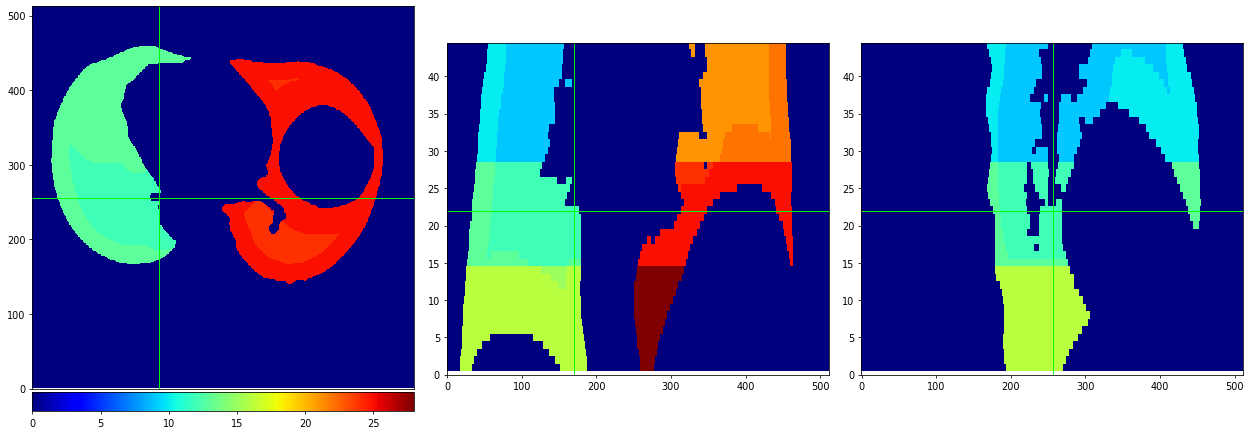

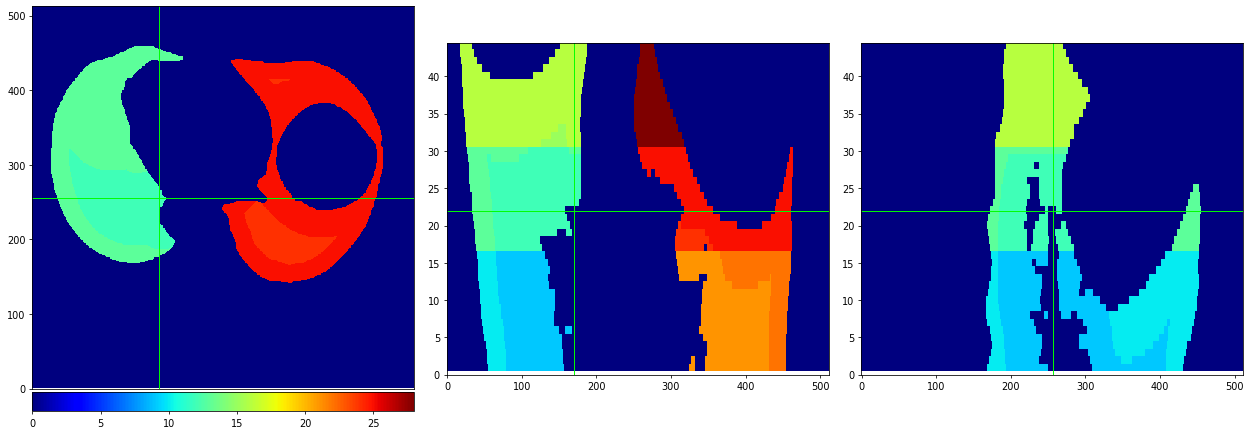

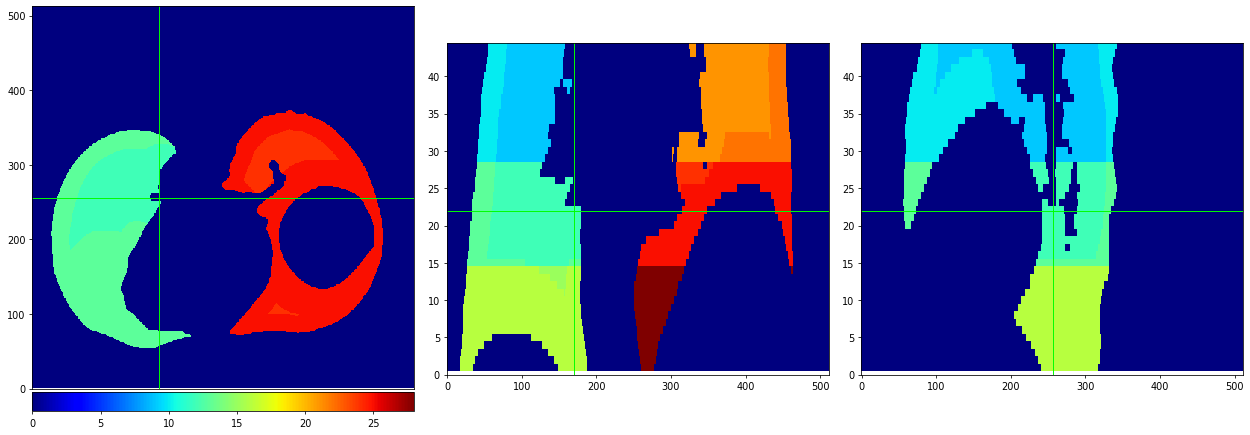

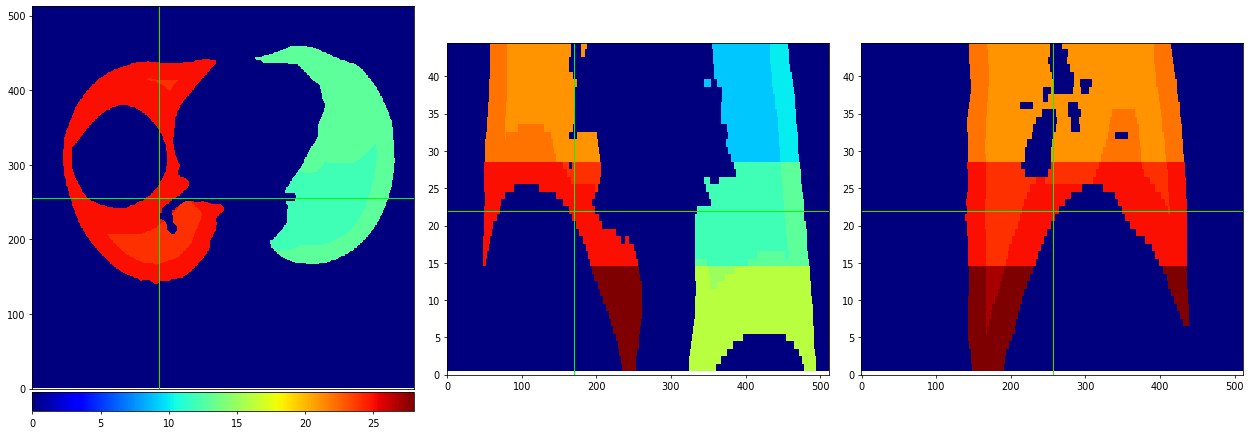

In [46]:
# # Test different orientations 
# SubDir = "/DATA/summer_students/process_AZ/cardiac_cleanup"
# for sub in Z_flipped[:1]: 
#     lung = nib.load(os.path.join(SubDir, f"{sub}_LUNG.nii.gz")).get_fdata()
#     tb = np.flip(lung, axis=2)
#     fb = np.flip(lung, axis=1)
#     lr = np.flip(lung, axis=0)
#     PLF.plot(lung, cmaps="jet", resolution=[1,1,10])
#     PLF.plot(tb, cmaps="jet", resolution=[1,1,10])
#     PLF.plot(fb, cmaps="jet", resolution=[1,1,10])
#     PLF.plot(lr, cmaps="jet", resolution=[1,1,10])    

In [32]:
# Specify an output directory for the flipped niftys - define int
SubDir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

output_dir_LR = '/DATA/summer_students/process_AZ/cardiac_LR'
output_dir_TB = '/DATA/summer_students/process_AZ/cardiac_TB'
output_dir_FB = '/DATA/summer_students/process_AZ/cardiac_FB'

# Create a top/bottom lung flipping function 
def invert_lung_TB(SubDir, ID, output_dir_TB):
    # Load the lung mask for the given ID
    lung = nib.load(os.path.join(SubDir, f"{ID}_LUNG.nii.gz")).get_fdata()
    
    # Vertically invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=2)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_TB, f"TB_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask, affine=None)
    nib.save(inverted_nifti, output_filename)

# Create a front/back lung flipping function 
def invert_lung_FB(SubDir, ID, output_dir_FB):
    # Load the lung mask for the given ID
    lung = nib.load(os.path.join(SubDir, f"{ID}_LUNG.nii.gz")).get_fdata()

    # Horizontally invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=1)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_FB, f"FB_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask, affine=None)
    nib.save(inverted_nifti, output_filename)
    
# Create a front/back lung flipping function 
def invert_lung_LR(SubDir, ID, output_dir_LR):
    # Load the lung mask for the given ID
    lung = nib.load(os.path.join(SubDir, f"{ID}_LUNG.nii.gz")).get_fdata()

    # Horizontally invert the lung mask
    inverted_lung_mask = np.flip(lung, axis=0)

    # Save the inverted lung mask as a NIfTI file
    output_filename = os.path.join(output_dir_LR, f"LR_{ID}_LUNG.nii.gz")
    inverted_nifti = nib.Nifti1Image(inverted_lung_mask, affine=None)
    nib.save(inverted_nifti, output_filename)

In [33]:
del Sub_sorted

In [53]:
# Sub_sorted = ['3010406', '3010414', "3011194", '3011232', '3011399', '3011704', '3011933', '3013561', '3014037', '3014061', '3014274', '3014410', '3014622', '3014673', '3014940', '3015025', '3015700', '3015815', '3016552', '3016900', '3017567', '3018407', '3018679', '3018741', '3019101', '3019845', '3022374', '3022862', '4010280', '4010612', '4011031', '4011562', '4011740', '4011783', '4012100', '4012631', '4012801', '4013638', '4013891', '4015720', '4015967', '4015983', '4016939', '4017935', '4018214', '4018389', '4018800', '4018877', '4019164', '4019261', '4019750', '4019970', '4021320', '4021959', '4022050', '4022130', '4022629', '4022874', '5010160', '5010195', '5010659', '5010888', '5011230', '5011485', '5011833', '5012236', '5012562', '5012570', '5012902', '5013143', '5014220', '5014778', '5014816', '5014891', '5015260', '5015464', '5015472', '5015952', '5016002', '5016363', '5016894', '5017432', '5017513', '5017548', '5017980', '5018099', '5018382', '5018790', '5018870', '5018960', '5021685', '5021715', '5021782', '5022509', '5022738', '5022754', '6010261', '6010393', '6010733', '6010768', '6010792', '6011098', '6011454', '6012450', '6012850', '6012973', '6013090', '6013392', '6013570', '6013783', '6014097', '6015620', '6016219', '6016391', '6016448', '6017002', '6017401', '6017835', '6018467', '6018858', '6019250', '6019706', '6021557', '6022065', '6022278', '6022421', '6022669', '6022944', '7010168', '7010435', '7010834', '7011784', '7012012', '7012365', '7012403', '7012551', '7012993', '7014813', '7014848', '7015097', '7015259', '7015917', '7017642', '7017871', '7018215', '7018576', '7018932', '7018940', '7019211', '7019408', '7019629', '7019955', '7040350', '7041403', '7042299', '7044194', '7044801', '7044976', '7044984', '8010358', '8010498', '8010900', '8011036', '8011966', '8012059', '8012440', '8012679', '8012695', '8013209', '8013381', '8014167', '8014957', '8015104', '8015198', '8015295', '8016526', '8016941', '8016968', '8017093', '8017409', '8017417', '8017506', '8017670', '8018219', '8018413', '8019509', '8019967', '8021244', '8021724', '8021988', '8022755', '8022909', '8022917', '8022925', '8023077', '8024278', '8024502', '8024642']

# for sub in Sub_sorted:
#     invert_lung_FB(SubDir, sub, output_dir_FB)
#     invert_lung_LR(SubDir, sub, output_dir_LR)
#     print(f"complete writing for {sub}")

complete writing for 3010406
complete writing for 3010414
complete writing for 3011194
complete writing for 3011232
complete writing for 3011399
complete writing for 3011704
complete writing for 3011933
complete writing for 3013561
complete writing for 3014037
complete writing for 3014061
complete writing for 3014274
complete writing for 3014410
complete writing for 3014622
complete writing for 3014673
complete writing for 3014940
complete writing for 3015025
complete writing for 3015700
complete writing for 3015815
complete writing for 3016552
complete writing for 3016900
complete writing for 3017567
complete writing for 3018407
complete writing for 3018679
complete writing for 3018741
complete writing for 3019101
complete writing for 3019845
complete writing for 3022374
complete writing for 3022862
complete writing for 4010280
complete writing for 4010612
complete writing for 4011031
complete writing for 4011562
complete writing for 4011740
complete writing for 4011783
complete writi

#### Classifier

In [14]:
Sub_sorted = ['3010406', '3010414', "3011194", '3011232', '3011399', '3011704', '3011933', '3013561', '3014037', '3014061', '3014274', '3014410', '3014622', '3014673', '3014940', '3015025', '3015700', '3015815', '3016552', '3016900', '3017567', '3018407', '3018679', '3018741', '3019101', '3019845', '3022374', '3022862', '4010280', '4010612', '4011031', '4011562', '4011740', '4011783', '4012100', '4012631', '4012801', '4013638', '4013891', '4015720', '4015967', '4015983', '4016939', '4017935', '4018214', '4018389', '4018800', '4018877', '4019164', '4019261', '4019750', '4019970', '4021320', '4021959', '4022050', '4022130', '4022629', '4022874', '5010160', '5010195', '5010659', '5010888', '5011230', '5011485', '5011833', '5012236', '5012562', '5012570', '5012902', '5013143', '5014220', '5014778', '5014816', '5014891', '5015260', '5015464', '5015472', '5015952', '5016002', '5016363', '5016894', '5017432', '5017513', '5017548', '5017980', '5018099', '5018382', '5018790', '5018870', '5018960', '5021685', '5021715', '5021782', '5022509', '5022738', '5022754', '6010261', '6010393', '6010733', '6010768', '6010792', '6011098', '6011454', '6012450', '6012850', '6012973', '6013090', '6013392', '6013570', '6013783', '6014097', '6015620', '6016219', '6016391', '6016448', '6017002', '6017401', '6017835', '6018467', '6018858', '6019250', '6019706', '6021557', '6022065', '6022278', '6022421', '6022669', '6022944', '7010168', '7010435', '7010834', '7011784', '7012012', '7012365', '7012403', '7012551', '7012993', '7014813', '7014848', '7015097', '7015259', '7015917', '7017642', '7017871', '7018215', '7018576', '7018932', '7018940', '7019211', '7019408', '7019629', '7019955', '7040350', '7041403', '7042299', '7044194', '7044801', '7044976', '7044984', '8010358', '8010498', '8010900', '8011036', '8011966', '8012059', '8012440', '8012679', '8012695', '8013209', '8013381', '8014167', '8014957', '8015104', '8015198', '8015295', '8016526', '8016941', '8016968', '8017093', '8017409', '8017417', '8017506', '8017670', '8018219', '8018413', '8019509', '8019967', '8021244', '8021724', '8021988', '8022755', '8022909', '8022917', '8022925', '8023077', '8024278', '8024502', '8024642']

In [15]:
# Create a function for selecting optimal x/y/z axis slice
def max_slice_indices(lung):
    slice_areas_z = np.sum(lung, axis=(0, 1))
    largest_area_z_index = np.argmax(slice_areas_z)
    
    slice_areas_x = np.sum(lung, axis=(1, 2))
    largest_area_x_index = np.argmax(slice_areas_x)
    
    slice_areas_y = np.sum(lung, axis=(0, 2))
    largest_area_y_index = np.argmax(slice_areas_y)
    
    return largest_area_x_index, largest_area_y_index, largest_area_z_index

# Create a function
def pix_sum(lung, xlc, ylc, zlc):
    pix = np.zeros((3,2,2))
    xx,yy,zz = lung.shape
    
    # axial plane - slicing on z axis 
    for i in range(2):
        for j in range(2):
            pix[0,i,1-j] = lung[i*xx//2:(i+1)*xx//2, j*yy//2:(j+1)*yy//2, zlc].mean()
            
    # coronal plane - slicing on y axis          
    for i in range(2):
        for j in range(2):
            pix[1,1-i,j] = lung[i*xx//2:(i+1)*xx//2, ylc, j*zz//2:(j+1)*zz//2].mean()
            
    # saggital plane - slicing on x axis         
    for i in range(2):
        for j in range(2):
            pix[2,i,j] = lung[xlc, i*yy//2:(i+1)*yy//2, j*zz//2:(j+1)*zz//2].mean()
            
    return pix

# def normalize_pixel_sums(lung, xlc, ylc, zlc):
#     # Calculate pixel sums for the three planes
#     pixel_sums = pix_sum(lung, xlc, ylc, zlc)
    
#     # Normalize each plane's pixel sums separately to [0, 1]
#     normalized_sums = pixel_sums - np.min(pixel_sums)
#     normalized_sums /= np.max(normalized_sums)
    
#     return normalized_sums

In [12]:
# # Getting X(flattened tensors) and y(labels (0, 1:LR, 2:TB, 3:FB))
# SubDir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

# X=[]
# y=[]

# for sub in Sub_sorted: 
#     lung = nib.load(os.path.join(SubDir, f"{sub}_LUNG.nii.gz")).get_fdata()
#     xlc, ylc, zlc = max_slice_indices(lung)
#     pix = pix_sum(lung, xlc, ylc, zlc)
#     X.append(pix.flatten())
#     y.append(0)

# for sub in Sub_sorted:
#     Dir = '/DATA/summer_students/process_AZ/cardiac_LR'
#     lung = nib.load(os.path.join(Dir, f"LR_{sub}_LUNG.nii.gz")).get_fdata()
#     xlc, ylc, zlc = max_slice_indices(lung)
#     pix = pix_sum(lung, xlc, ylc, zlc)
#     X.append(pix.flatten())
#     y.append(1)
    
# for sub in Sub_sorted:
#     Dir = '/DATA/summer_students/process_AZ/cardiac_TB'
#     lung = nib.load(os.path.join(Dir, f"TB_{sub}_LUNG.nii.gz")).get_fdata()
#     xlc, ylc, zlc = max_slice_indices(lung)
#     pix = pix_sum(lung, xlc, ylc, zlc)
#     X.append(pix.flatten())
#     y.append(2)
    
# for sub in Sub_sorted:
#     Dir = output_dir_FB = '/DATA/summer_students/process_AZ/cardiac_FB'
#     lung = nib.load(os.path.join(Dir, f"FB_{sub}_LUNG.nii.gz")).get_fdata()
#     xlc, ylc, zlc = max_slice_indices(lung)     
#     pix = pix_sum(lung, xlc, ylc, zlc)
#     X.append(pix.flatten())
#     y.append(3)
    
# print(len(X), len(y))

In [18]:
# Get trainning and testing dat
SubDir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

def extract_feature(sub):
    X = list()
    y = list()
    lung = nib.load(os.path.join(SubDir, f"{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(0)


    Dir = '/DATA/summer_students/process_AZ/cardiac_LR'
    lung = nib.load(os.path.join(Dir, f"LR_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(1)


    Dir = '/DATA/summer_students/process_AZ/cardiac_TB'
    lung = nib.load(os.path.join(Dir, f"TB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(2)


    Dir = '/DATA/summer_students/process_AZ/cardiac_FB'
    lung = nib.load(os.path.join(Dir, f"FB_{sub}_LUNG.nii.gz")).get_fdata()
    xlc, ylc, zlc = max_slice_indices(lung)     
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    y.append(3)

    np.save(f'./cardiac_features/{sub}.npy', np.hstack((np.array(X), np.array(y)[:,np.newaxis])))

ParallelMe(extract_feature, Sub_sorted, n_cores=15).run()

  0%|          | 0/198 [00:00<?, ?it/s]

In [19]:
X = list()
y = list()
for sub in tqdm(Sub_sorted):
    data = np.load(f'./cardiac_features/{sub}.npy')
    X.extend(list(data[:, :12]))
    y.extend(list(data[:, -1]))
X = np.array(X)
y = np.array(y)
X.shape, y.shape

  0%|          | 0/198 [00:00<?, ?it/s]

((792, 12), (792,))

In [22]:
classifier = SVC(kernel='linear', C=1.0, random_state=42)
scores = cross_val_score(classifier, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.02


In [29]:
# Assuming y is an array of labels corresponding to each tensor
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
# classifier = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence
classifier = SVC(kernel='linear', C=1.0)
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
# classifier = KNeighborsClassifier(n_neighbors=5) # try not to use this as comp time too long 

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the testing set
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.957983193277311


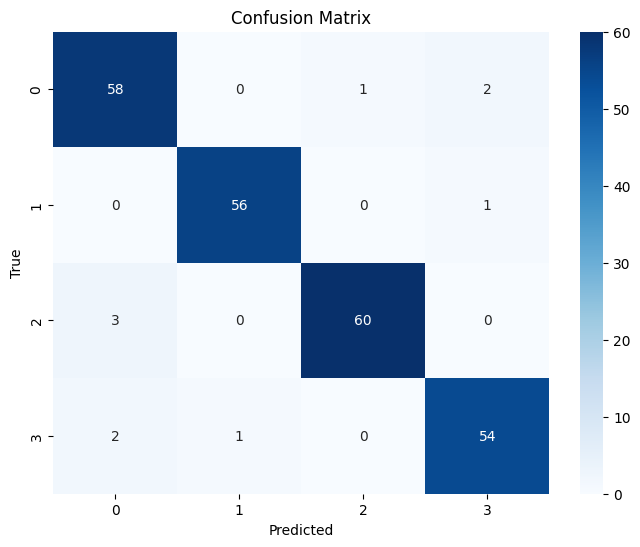

In [30]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [31]:
import joblib

joblib.dump(classifier, 'cardiac_flip_classifier.pkl')

['cardiac_flip_classifier.pkl']

In [32]:
# Load the saved model
classifier = joblib.load('cardiac_flip_classifier.pkl')

#### Write a function that takes lung mask and return axis to flip on 

In [33]:
def cardiac_flip_classify(lung): 
    X = []
    xlc, ylc, zlc = max_slice_indices(lung)
    pix = pix_sum(lung, xlc, ylc, zlc)
    X.append(pix.flatten())
    prediction = classifier.predict(X)
    if prediction == 0:
        pass
    else: 
        print(f"{prediction} axis flip predicted")
        return prediction

In [34]:
# Getting X(flattened tensors) and y(labels (0, 1:LR, 2:TB, 3:FB))
SubDir = "/DATA/summer_students/process_AZ/cardiac_cleanup"

predictions = []
for sub in Sub_sorted:
    lung = nib.load(os.path.join(SubDir, f"{sub}_LUNG.nii.gz")).get_fdata()
    prediction = cardiac_flip_classify(lung)
    predictions.append(prediction)
    
print(predictions)

[3.] axis flip predicted
[3.] axis flip predicted
[3.] axis flip predicted
[2.] axis flip predicted
[3.] axis flip predicted
[3.] axis flip predicted
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, array([3.]), None, None, None, None, None, array([3.]), None, array([3.]), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, array([2.]), None, None, None, None, None, None, None, None, None, None, array([3.]), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None